In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
# import Documents/AAIC/case studies/Quora/distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore")
from utills import utills
from fuzzywuzzy import fuzz

In [2]:
df = pd.read_csv('train.csv')
print('Number of data points:', df.shape[0])

Number of data points: 404290


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<h2> Distribution of data points among output classes

<h3> number of duplicates and non duplicates questions

<AxesSubplot:xlabel='is_duplicate'>

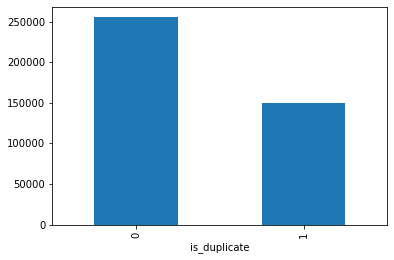

In [5]:
df.groupby('is_duplicate')['id'].count().plot.bar()

around 25K questions are not duplicate and 15k are duplicate questions

In [6]:
print('Question pair that are not similiar(is_duplicate = 0) :\n {}%'.format(100 - round(df['is_duplicate'].mean()*100,2)))
print("Question pairs that are similiar (is_dupicate = 1):\n {}%".format(round(df['is_duplicate'].mean() *100,2),2))

Question pair that are not similiar(is_duplicate = 0) :
 63.08%
Question pairs that are similiar (is_dupicate = 1):
 36.92%


In [7]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_asked_more_then_one_time = np.sum(qids.value_counts()>1)

print('Total Number of unique questions are :\n{}'.format(unique_qs))

print('Number of unique questions are that appeared more then 1 time :\n{} ({}%)'.format(qs_asked_more_then_one_time, qs_asked_more_then_one_time/unique_qs *100))

print('Max number of times a single question is repeated :\n{}'.format(max(qids.value_counts())))

Total Number of unique questions are :
537933
Number of unique questions are that appeared more then 1 time :
111780 (20.77953945937505%)
Max number of times a single question is repeated :
157


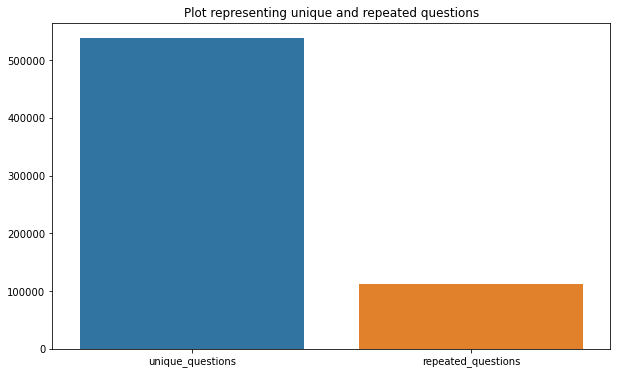

In [8]:
x = ['unique_questions', 'repeated_questions']
y = [unique_qs, qs_asked_more_then_one_time]

plt.figure(figsize = (10,6))
plt.title('Plot representing unique and repeated questions')
sns.barplot(x,y)
plt.show()

<h2> checking for duplicates

In [9]:
pair_duplicates = df.groupby(['qid1', 'qid2']).count().reset_index()
print('Number of duplicates questions pair {}'.format(len(pair_duplicates) - len(df)))

Number of duplicates questions pair 0


<h2> Number of occurances of each question

Maximum number of time a question is repeated:
157


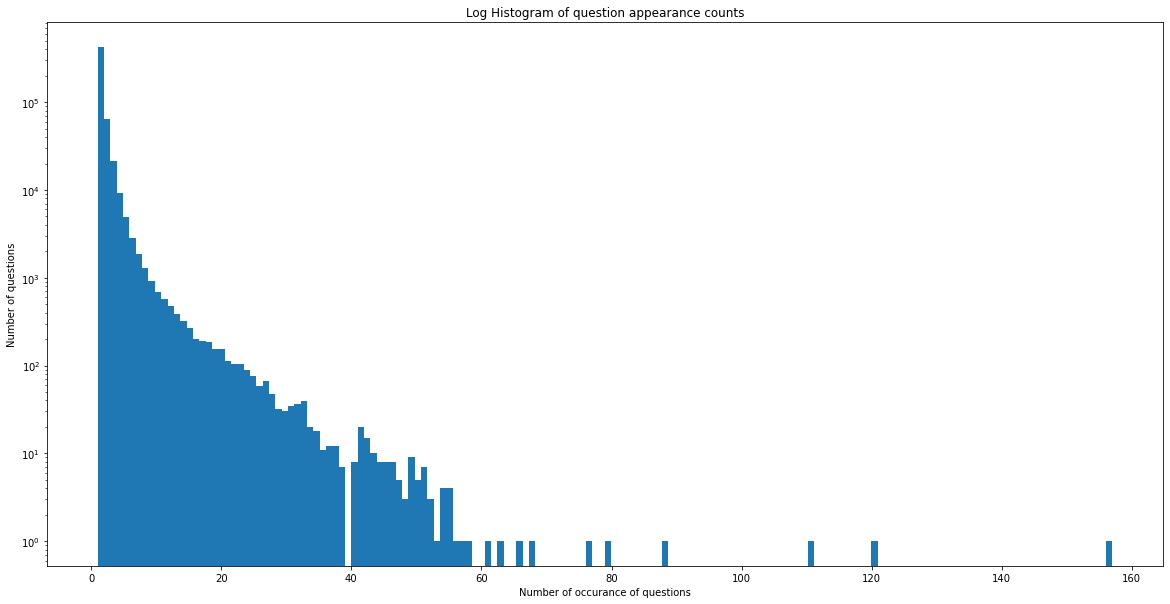

In [10]:
plt.figure(figsize = (20,10))
plt.hist(qids.value_counts(), bins = 160)
plt.yscale('log', nonposy = 'clip')
plt.title('Log Histogram of question appearance counts')
plt.xlabel('Number of occurance of questions')
plt.ylabel('Number of questions')
print("Maximum number of time a question is repeated:\n{}".format(max(qids.value_counts())))

<h2> checking for nan values

In [11]:
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [12]:
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h1> Basic Feature Extraction 

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [13]:
def normalized_word_common(row):
    w1 = set(map(lambda word:word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word:word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * (len(w1 & w2))

def normalized_word_total(row):
    w1 = set(map(lambda word:word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word:word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * (len(w1) + len(w2))

def normalized_word_share(row):
    w1 = set(map(lambda word:word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word:word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))


In [14]:
if os.path.isfile('df_basic_fe.csv'):
    df = pd.read_csv('df_basic_fe.csv')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row : len(row.split(' ')))
    df['q2_n_words'] = df['question2'].apply(lambda row:len(row.split(' ')))
    df['word_common'] = df.apply(normalized_word_common, axis = 1)
    df['word_total'] = df.apply(normalized_word_total, axis = 1)
    df['word_share'] = df.apply(normalized_word_share, axis = 1)
    df['freq_q1+freq_q2'] = df['freq_qid1'] + df['freq_qid2']
    df['freq_q1-freq_q2'] = df['freq_qid1'] - df['freq_qid2']
    
    df.to_csv('df_basic_fe.csv', index=False)
    
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+freq_q2,freq_q1-freq_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h2> Analysis on some of the extracted features </h2>

In [15]:
print('Minimum length of questions in question 1:\n', min(df['q1_n_words']))
print('Minimum length of questions in question 2:\n', min(df['q2_n_words']))
print("Number of questions with mimimum length in question 1:\n", df[df['q1_n_words'] == 1].shape[0])
print("Number of questions with mimimum length in question 2:\n", df[df['q2_n_words'] == 1].shape[0])

Minimum length of questions in question 1:
 1
Minimum length of questions in question 2:
 1
Number of questions with mimimum length in question 1:
 67
Number of questions with mimimum length in question 2:
 24


In [16]:
print('Maximum length of questions in question 1:\n', max(df['q1_n_words']))
print('Maximum length of questions in question 2:\n', max(df['q2_n_words']))
print("Number of questions with maximum length in question 1:\n", df[df['q1_n_words'] == 125].shape[0])
print("Number of questions with maximum length in question 2:\n", df[df['q2_n_words'] == 237].shape[0])

Maximum length of questions in question 1:
 125
Maximum length of questions in question 2:
 237
Number of questions with maximum length in question 1:
 1
Number of questions with maximum length in question 2:
 13


<h2> Feature: word_share

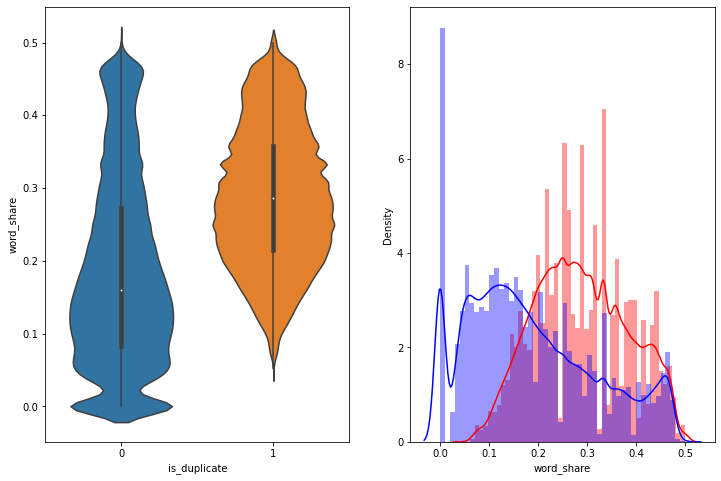

In [17]:
plt.figure(figsize = (12,8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1]['word_share'], label = '1', color = 'red')
sns.distplot(df[df['is_duplicate'] == 0]['word_share'], label = '0', color='blue')
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h2> word common feature </h2>

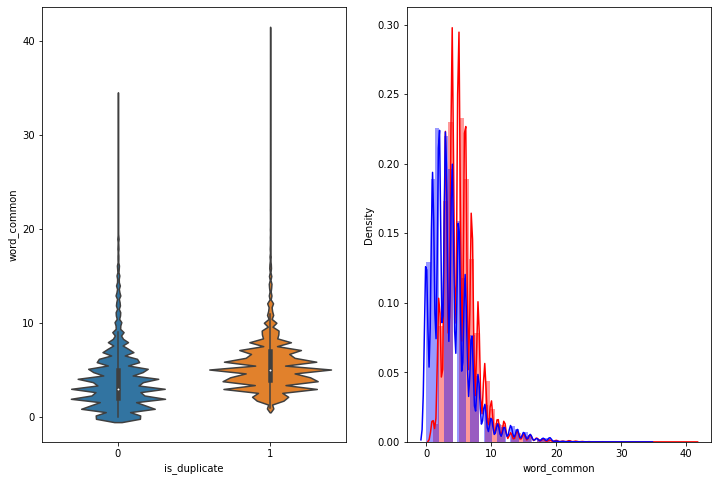

In [18]:
plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_common', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1]['word_common'], label = '1', color = 'red')
sns.distplot(df[df['is_duplicate']==0]['word_common'], label = '0',color='blue')
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

<h2>text Preprocessing 

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [19]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

<h2> Advanced Feature extraction based on NLP and fuzzy logic

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [20]:
def get_token_features(q1, q2):
    token_features = [0.0] * 10
    
    #converting sentences into tokens
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0 :
        return token_features
    #get the non stopwords in the questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #get the stopwords in questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    #get the common non_stopwords from question pair
    common_word_count = len(q1_words.intersection(q2_words))
    #get the common stopwords from question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    #get the common tokens from the question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # check last word is common or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    #check first word is common or not 
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    #__abs_len_diff__
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #avg token length in both questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    
    return token_features

In [21]:
# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    len_strs = utills.lcs(a,b)
    if len_strs == 0:
        return 0
    else:
        return len_strs / (min(len(a), len(b)) + 1)

In [22]:
get_longest_substr_ratio("AAA","BBBA")

0.25

In [23]:
def extract_features(df):
    df['question1'] = df['question1'].fillna("").apply(preprocess)
    df['question2'] = df['question2'].fillna("").apply(preprocess)
    
    print('token features...')
    
    #merging features with the dataset
    
    token_features = df.apply(lambda x : get_token_features(x['question1'], x['question2']), axis = 1)
    
    df['cwc_min'] = list(map(lambda x : x[0], token_features))
    df['cwc_max'] = list(map(lambda x : x[1], token_features))
    df['csc_min'] = list(map(lambda x : x[2], token_features))
    df['csc_max'] = list(map(lambda x : x[3], token_features))
    df['ctc_min'] = list(map(lambda x : x[4], token_features))
    df['ctc_max'] = list(map(lambda x : x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
     #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [24]:
if os.path.isfile('quora_nlp_features.csv'):
    df = pd.read_csv('quora_nlp_features.csv')
    df.fillna('')
else:
    print('Extracting features for train:')
    df = extract_features(df)
    df.to_csv('quora_nlp_features.csv', index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.884615


<h1> Analysis of extracted features </h1>
<h3> Plotting Word Clouds
    

In [25]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_dupicate = df[df['is_duplicate'] == 0]

#converting 2s array of q1 and q2 and flatten the array like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate['question1'],df_duplicate['question2']]).flatten()
n = np.dstack([df_duplicate['question2'], df_duplicate['question2']]).flatten()

print('Number of data points in class 1 (duplicate pairs):', len(p))
print("Number of data points in class 0(non duplicate pairs)", len(n))

#saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt = '%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt = '%s')

Number of data points in class 1 (duplicate pairs): 298526
Number of data points in class 0(non duplicate pairs) 298526


In [26]:
# reading the text files and removing the Stop Words:
from wordcloud import WordCloud, STOPWORDS
d = os.path.dirname('.')

textp_w = open(os.path.join(d, 'train_p.txt')).read()
textn_w = open(os.path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109860
Total number of words in non duplicate pair questions : 16123874


word cloud for duplicate pairs


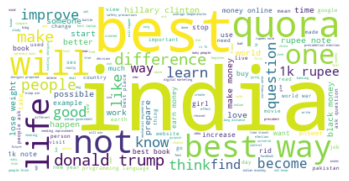

In [27]:
wc = WordCloud(background_color='white',max_words = len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print('word cloud for duplicate pairs')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Word cloud for non duplicate pairs


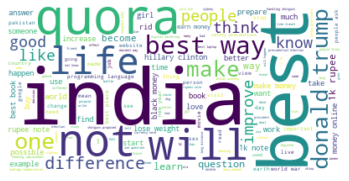

In [28]:
wc = WordCloud(background_color='white', max_words=len(textn_w), stopwords = stopwords)
wc.generate(textn_w)
print('Word cloud for non duplicate pairs')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<h2> pair plots of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

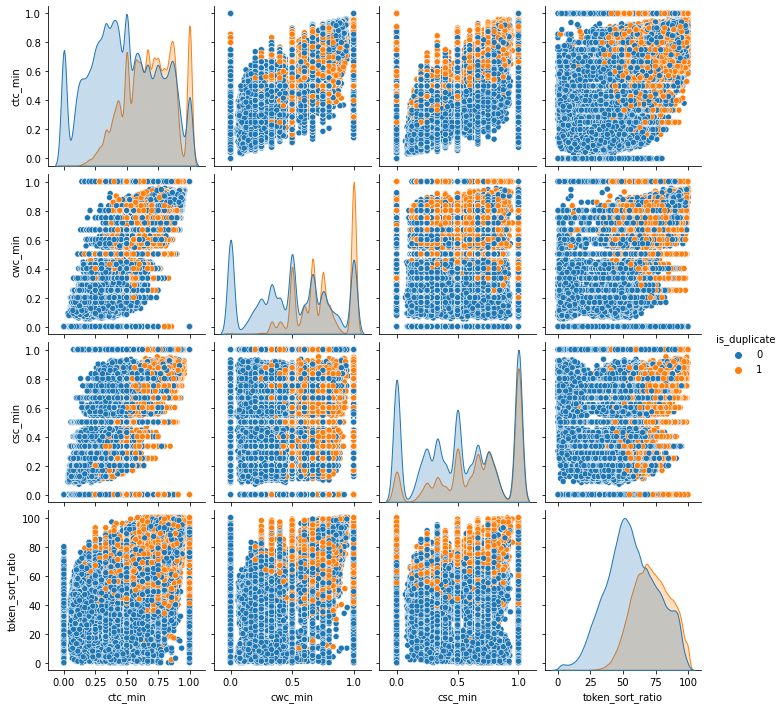

In [29]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue = 'is_duplicate', vars =['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] )

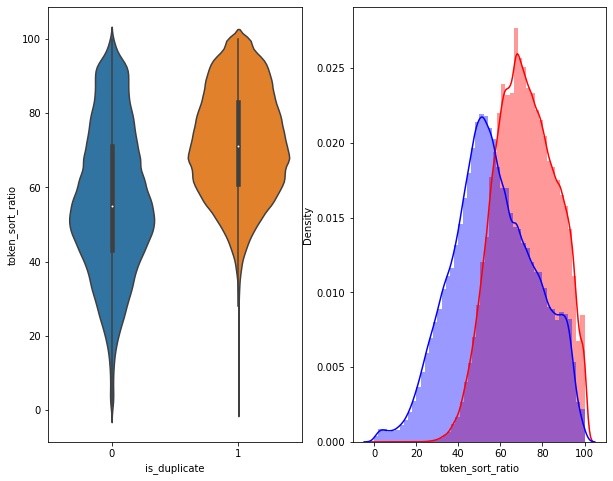

In [30]:
#distribution of token_sort_ratio

plt.figure(figsize = (10,8))
plt.subplot(1,2,1)

sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:], label = '1', color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:], label = '2', color = 'blue')
plt.show()

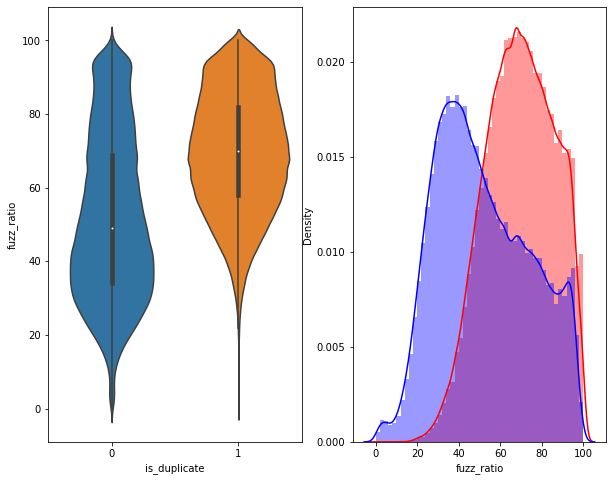

In [31]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h2> Visualization

In [32]:
#using TSNE for dimentionality reduction

from sklearn.preprocessing import MinMaxScaler
dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [33]:
from sklearn.manifold import TSNE

In [34]:
tsne2d = TSNE(
    n_components = 2, 
    init = 'random',
    random_state = 101,
    method = 'barnes_hut',
    n_iter = 1000,
    verbose = 2,
    angle =0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.008s...
[t-SNE] Computed neighbors for 5000 samples in 0.215s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.126834
[t-SNE] Computed conditional probabilities in 0.119s
[t-SNE] Iteration 50: error = 81.4471130, gradient norm = 0.0451647 (50 iterations in 0.947s)
[t-SNE] Iteration 100: error = 70.7303772, gradient norm = 0.0086911 (50 iterations in 0.794s)
[t-SNE] Iteration 150: error = 68.9812775, gradient norm = 0.0056124 (50 iterations in 0.778s)
[t-SNE] Iteration 200: error = 68.1358566, gradient norm = 0.0048159 (50 iterations in 0.771s)
[t-SNE] Iteration 250: error = 67.5959625, gradient norm = 0.0030867

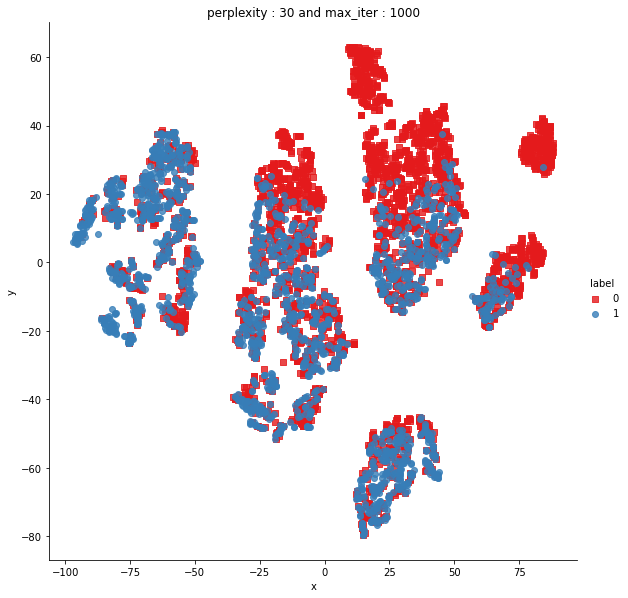

In [35]:
df_tsne2d = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df_tsne2d, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [36]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.007s...
[t-SNE] Computed neighbors for 5000 samples in 0.231s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.126834
[t-SNE] Computed conditional probabilities in 0.125s
[t-SNE] Iteration 50: error = 80.3314514, gradient norm = 0.0296921 (50 iterations in 1.697s)
[t-SNE] Iteration 100: error = 69.2787857, gradient norm = 0.0033776 (50 iterations in 1.059s)
[t-SNE] Iteration 150: error = 67.8232956, gradient norm = 0.0016229 (50 iterations in 0.990s)
[t-SNE] Iteration 200: error = 67.2680511, gradient norm = 0.0010855 (50 iterations in 0.961s)
[t-SNE] Iteration 250: error = 66.9466095, gradient norm = 0.0008996

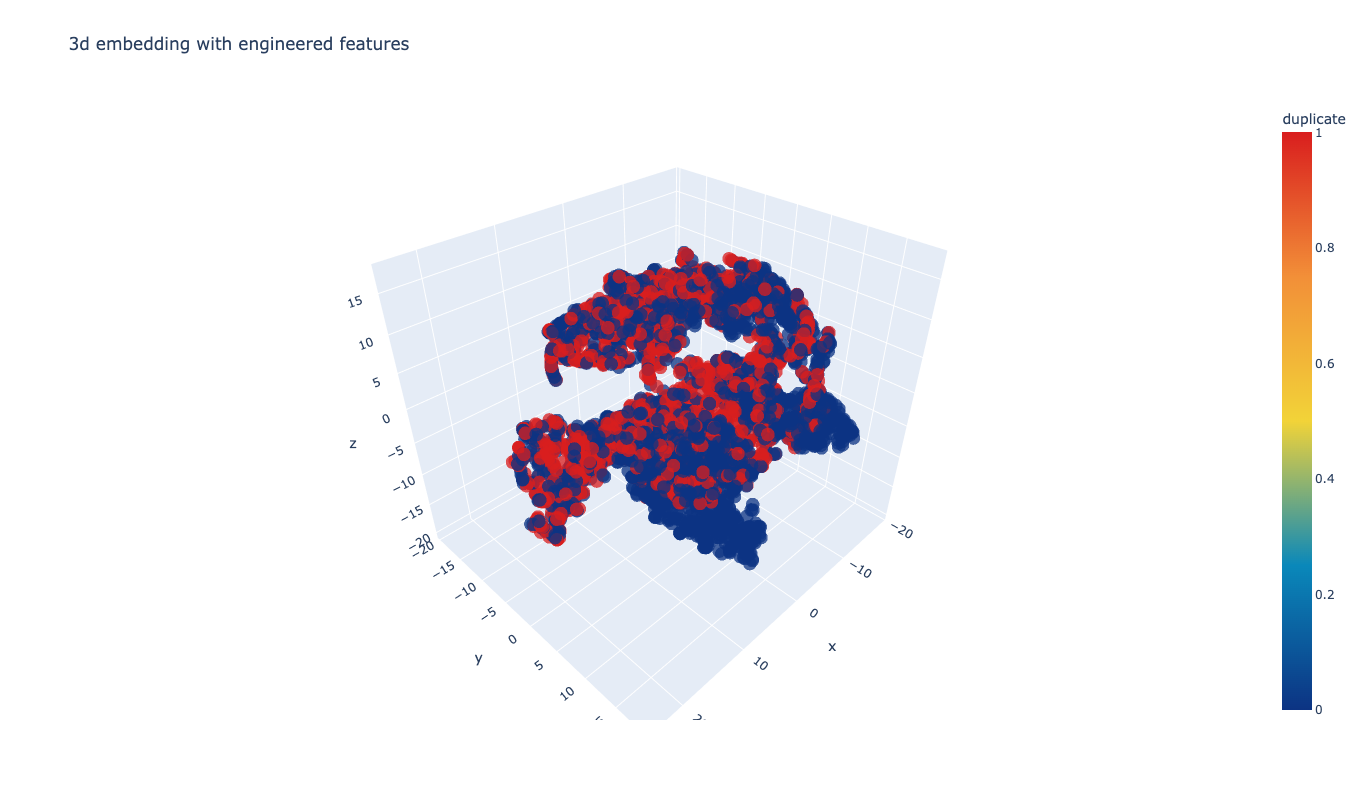

In [37]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

<h1> Featuring text data with tdidf weighted word-vectors

In [38]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.884615
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.600000
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.411765
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.675000


In [39]:
df['question1'] = df['question1'].apply(lambda x :str(x))
df['question2'] = df['question2'].apply(lambda x:str(x))

In [40]:
#merge texts
questions = list(df['question1'] + list(df['question2']))
tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)
words2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [45]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
import spacy

#intially would require to run following commands in console to have spacy pretrained vectors
#python -m spacy download en
#python -m spacy link en_core_web_sm en_core_web_sm
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|██████████| 404290/404290 [33:35<00:00, 200.54it/s]   


In [47]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [24:25<00:00, 275.82it/s]


In [67]:
print(df['q1_feats_m'])


0         [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
1         [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
2         [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
3         [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
4         [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
                                ...                        
404285    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
404286    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
404287    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
404288    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
404289    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
Name: q1_feats_m, Length: 404290, dtype: object


In [54]:
if not os.path.isfile('final_features.csv'):
    df.to_csv('final_features.csv', index=False)
else:
    df = pd.read_csv('final_features.csv')
df.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,...,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,q1_feats_m,q2_feats_m
0,0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,...,1.0,2.0,13.0,100,93,93,100,0.982759,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
1,1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,...,1.0,5.0,12.5,86,63,66,75,0.884615,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
2,2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,...,1.0,4.0,12.0,63,63,43,47,0.600000,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
3,3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,...,0.0,2.0,12.0,28,24,9,14,0.411765,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
4,4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,...,1.0,6.0,10.0,67,47,35,56,0.675000,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...


In [55]:
print("Number of features in the dataframe :", df.shape[1])

Number of features in the dataframe : 35


In [56]:
df1 = pd.DataFrame(df.q1_feats_m.values.tolist())


In [57]:
df1.shape[1]

1

In [58]:
print(df1)

                                                        0
0       [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
1       [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
2       [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
3       [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
4       [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
...                                                   ...
404285  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
404286  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
404287  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
404288  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
404289  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...

[404290 rows x 1 columns]


In [60]:
df3_q1 = pd.DataFrame(df.q1_feats_m.values.tolist(), index= df.index)

In [61]:
print(df3_q1.shape[0])

404290


In [65]:
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [66]:
print(df3_q1.shape[1])

1
